# 作业说明

请填写代码以完成作业，并将整个包以 zip 文件的形式提交到网络学堂

# 第一步

运行以下代码以导入你需要的模块，如需要你也可以修改此代码（例如，导入更多模块）

In [1]:
import numpy as np
import wave
import math
import matplotlib.pyplot as plt

In [2]:
def nextpow2(n):
    '''
    求最接近数据长度的2的整数次方
    An integer equal to 2 that is closest to the length of the data
    
    Eg: 
    nextpow2(2) = 1
    nextpow2(2**10+1) = 11
    nextpow2(2**20+1) = 21
    '''
    return np.ceil(np.log2(np.abs(n))).astype('long')

def berouti(SNR):
    if -5.0 <= SNR <= 20.0:
        a = 4 - SNR * 3 / 20
    else:
        if SNR < -5.0:
            a = 5
        if SNR > 20:
            a = 1
    return a

def berouti1(SNR):
    if -5.0 <= SNR <= 20.0:
        a = 3 - SNR * 2 / 20
    else:
        if SNR < -5.0:
            a = 4
        if SNR > 20:
            a = 1
    return a

def find_index(x_list):
    index_list = []
    for i in range(len(x_list)):
        if x_list[i] < 0:
            index_list.append(i)
    return index_list


# 问题1：音频去噪

对于有噪声的音频，我们希望使用一些方法将噪声水平尽可能减小

这里我们采用谱减法去噪

首先我们初始化一些参数与数据

C:\Users\admin\AppData\Local\Temp\ipykernel_31452\4253078402.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = np.fromstring(str_data, dtype=np.short)


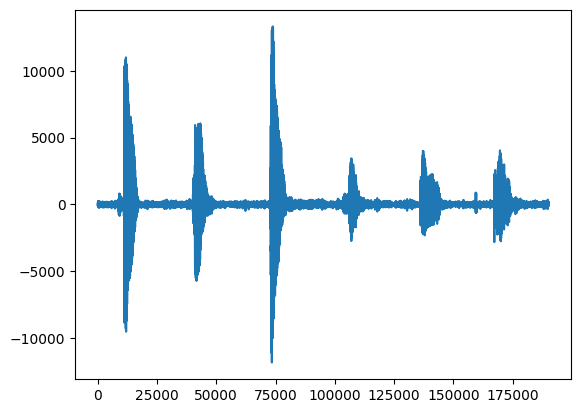

In [9]:
f = wave.open("input_file.wav")
params = f.getparams()
nchannels, sampwidth, framerate, nframes = params[:4]
fs = framerate

str_data = f.readframes(nframes)
f.close()
x = np.fromstring(str_data, dtype=np.short)

len_ = 20 * fs // 1000
PERC = 50
len1 = len_ * PERC // 100
len2 = len_ - len1

Thres = 3
Expnt = 2.0
beta = 0.002
G = 0.9

## 1.1 噪声估计

要想去除噪声，首先我们需要从信号中估计噪声

这里假定音频数据的前5帧是静音（无信息音频）即只含有噪声

In [39]:
# 初始化汉明窗
win = np.hamming(len_)
winGain = len2 / sum(win)

# 噪声幅度计算
nFFT = 2 * 2 ** (nextpow2(len_))
noise_mean = np.zeros(nFFT)

j = 0
for k in range(1, 6):
    ####################
    noise_mean += abs(np.fft.fft(win * (x[(k - 1) * len_: (k * len_)]), nFFT))
    ####################
    j = j + len_

noise_mu = noise_mean / 5

In [40]:
# 分配内存并初始化各种变量
k = 1
img = 1j
x_old = np.zeros(len1)
Nframes = len(x) // len2 - 1
xfinal = np.zeros(Nframes * len2)

## 1.2 噪声去除

现在我们将采用谱减法去除噪声

你需要完成去噪过程中的一些重要操作

你可以参考下图来回忆过程

<img src="principle.png" align='middle'>

In [41]:
for n in range(0, Nframes):
    # 窗口
    insign = win * x[k - 1: k + len_ - 1]
    # FFT
    spec = np.fft.fft(insign, nFFT)
    # 计算幅值
    sig = abs(spec)
    # 存储相位信息
    theta = np.angle(spec)

    # 信噪比计算
    SNRseg = 0
    ####################
    SNRseg = 10 * np.log10(np.sum(sig ** 2) / np.sum(noise_mu ** 2))
    ####################
    

    if Expnt == 1.0:
        alpha = berouti1(SNRseg)
    else:
        alpha = berouti(SNRseg)

    # 谱减
    sub_speech = np.zeros(theta.shape)
    ####################
    sub_speech = sig ** Expnt - alpha * noise_mu ** Expnt
    ####################


    # 当纯净信号小于噪声信号时的处理
    diffw = sub_speech - beta * noise_mu ** Expnt
    z = find_index(diffw)
    if len(z) > 0:
        sub_speech[z] = beta * noise_mu[z] ** Expnt
    
    # 更新噪声频谱
    if SNRseg < Thres:  
        noise_temp = G * noise_mu ** Expnt + (1 - G) * sig ** Expnt
        noise_mu = noise_temp ** (1 / Expnt)

    # 信号恢复
    sub_speech[nFFT // 2 + 1:nFFT] = np.flipud(sub_speech[1:nFFT // 2])
    x_phase = np.zeros(theta.shape)
    ####################
    x_phase = sub_speech ** (1 / Expnt) * np.exp(img * theta)
    ####################
    xi = np.fft.ifft(x_phase).real

    # 重叠叠加
    xfinal[k - 1: k + len2 - 1] = x_old + xi[0: len1]
    x_old = xi[0 + len1: len_]
    k = k + len2

In [42]:
# 保存结果
wf = wave.open('en_outfile.wav', 'wb')
wf.setparams(params)
wave_data = (winGain * xfinal).astype(np.short)
wf.writeframes(wave_data.tostring())
wf.close()

C:\Users\admin\AppData\Local\Temp\ipykernel_31452\211117073.py:5: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  wf.writeframes(wave_data.tostring())


## 1.3 结果展示

现在采用方法展示音频去噪的结果

展示方法采用波形图的形式

C:\Users\admin\AppData\Local\Temp\ipykernel_31452\2801102163.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  xin = np.fromstring(str_data, dtype=np.short)
C:\Users\admin\AppData\Local\Temp\ipykernel_31452\2801102163.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  xout = np.fromstring(str_data, dtype=np.short)


Text(0.5, 1.0, 'output')

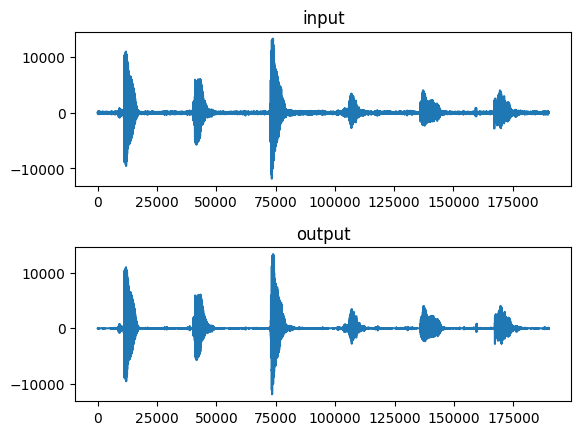

In [49]:
# 输入数据
f = wave.open("input_file.wav")
params = f.getparams()
nchannels, sampwidth, framerate, nframes = params[:4]
fs = framerate
str_data = f.readframes(nframes)
f.close()
xin = np.fromstring(str_data, dtype=np.short)

# 输出数据
f = wave.open("en_outfile.wav")
params = f.getparams()
nchannels, sampwidth, framerate, nframes = params[:4]
fs = framerate
str_data = f.readframes(nframes)
f.close()
xout = np.fromstring(str_data, dtype=np.short)

####################
plt.subplots_adjust(hspace=0.4)
plt.subplot(2, 1, 1)
plt.plot(xin)
plt.title('input')
plt.subplot(2, 1, 2)
plt.plot(xout)
plt.title('output')
####################